Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Primeras filas:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female

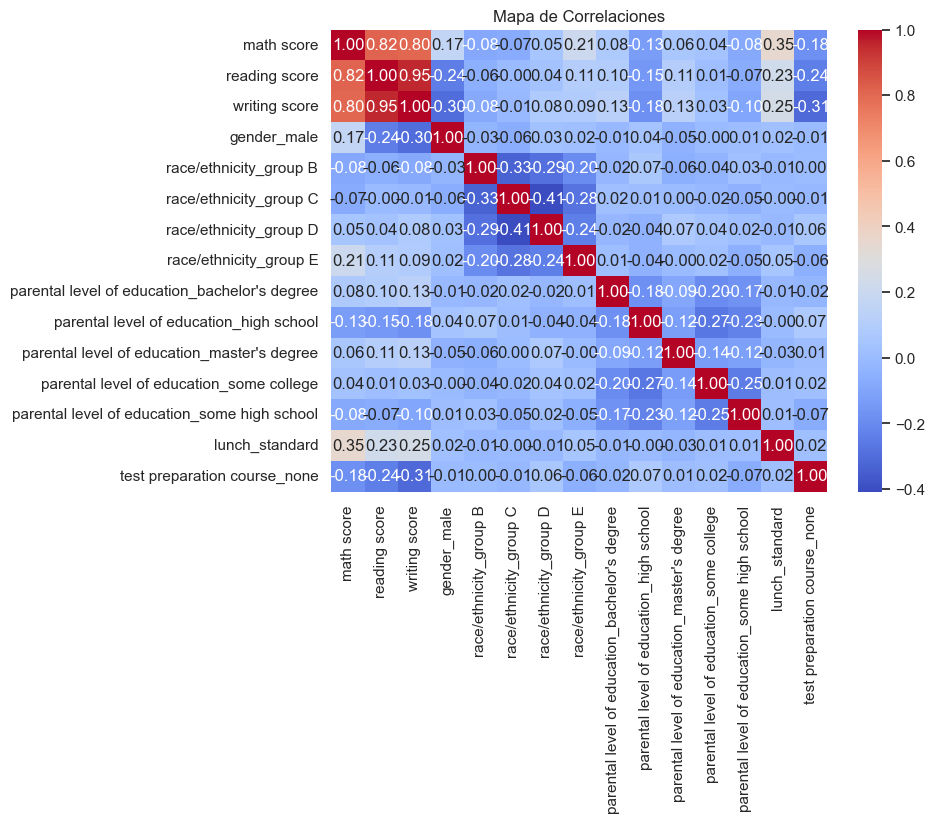


Resumen de feature selection:
                                               corr_abs     skb_score  \
reading score                                  0.954598  10248.019383   
math score                                     0.802642   1807.216666   
test preparation course_none                   0.312946    108.350892   
gender_male                                    0.301225     99.591576   
lunch_standard                                 0.245769     64.156643   
parental level of education_high school        0.182211     34.272381   
parental level of education_bachelor's degree  0.128297     16.702095   
parental level of education_master's degree    0.125693     16.020145   
parental level of education_some high school   0.097326      9.543717   
race/ethnicity_group E                         0.089077      7.982143   
race/ethnicity_group D                         0.082032      6.761254   
race/ethnicity_group B                         0.078254      6.149098   
parental level of ed

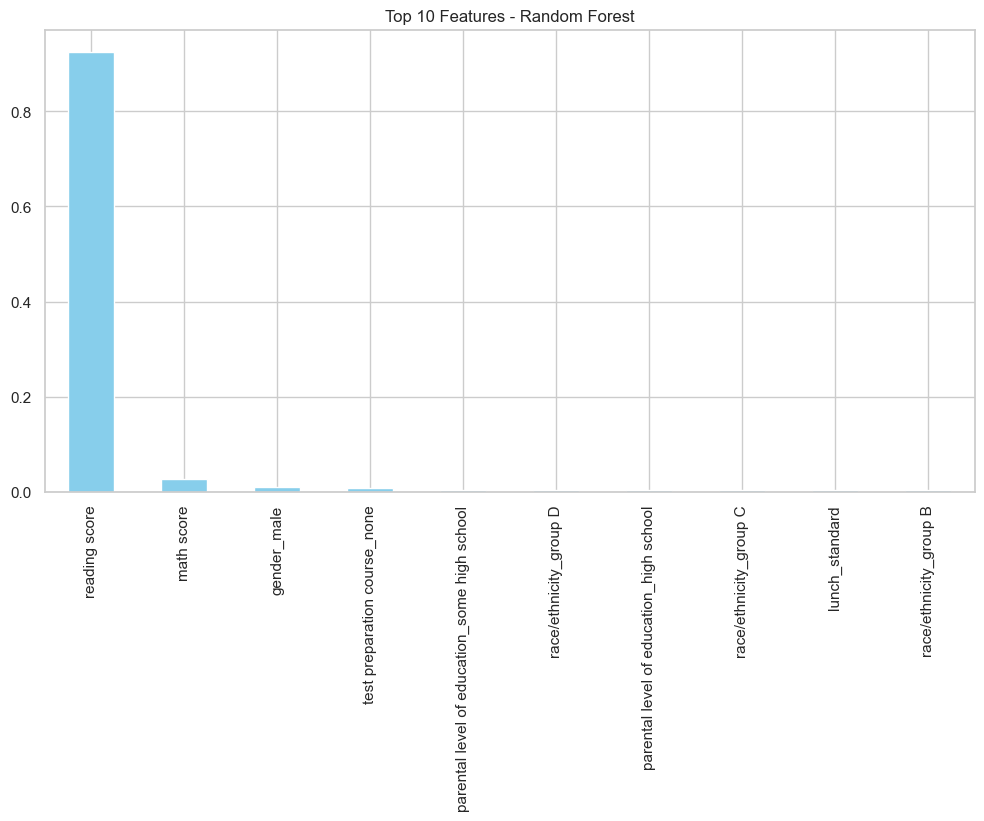

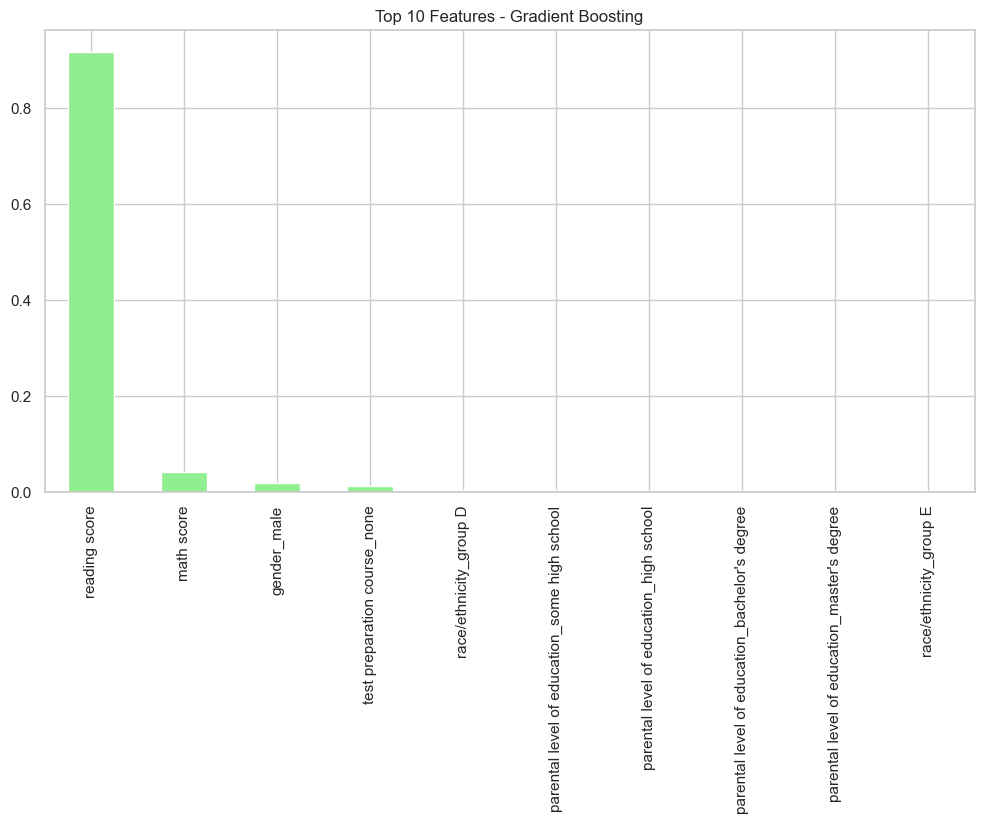

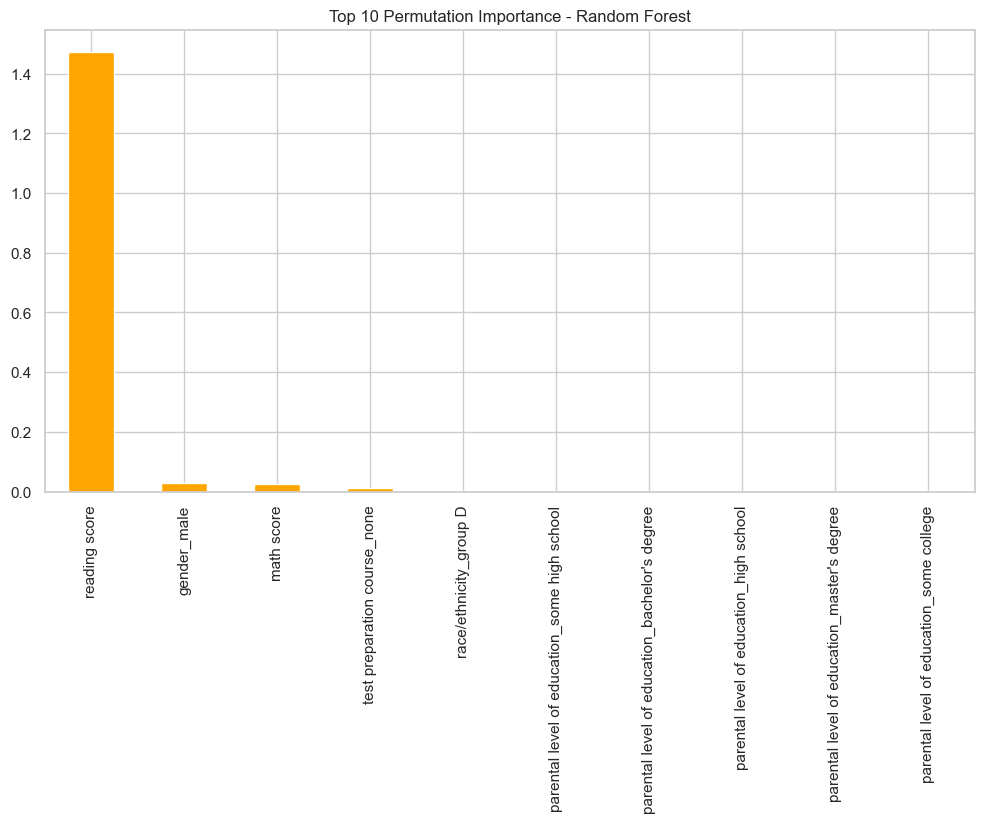

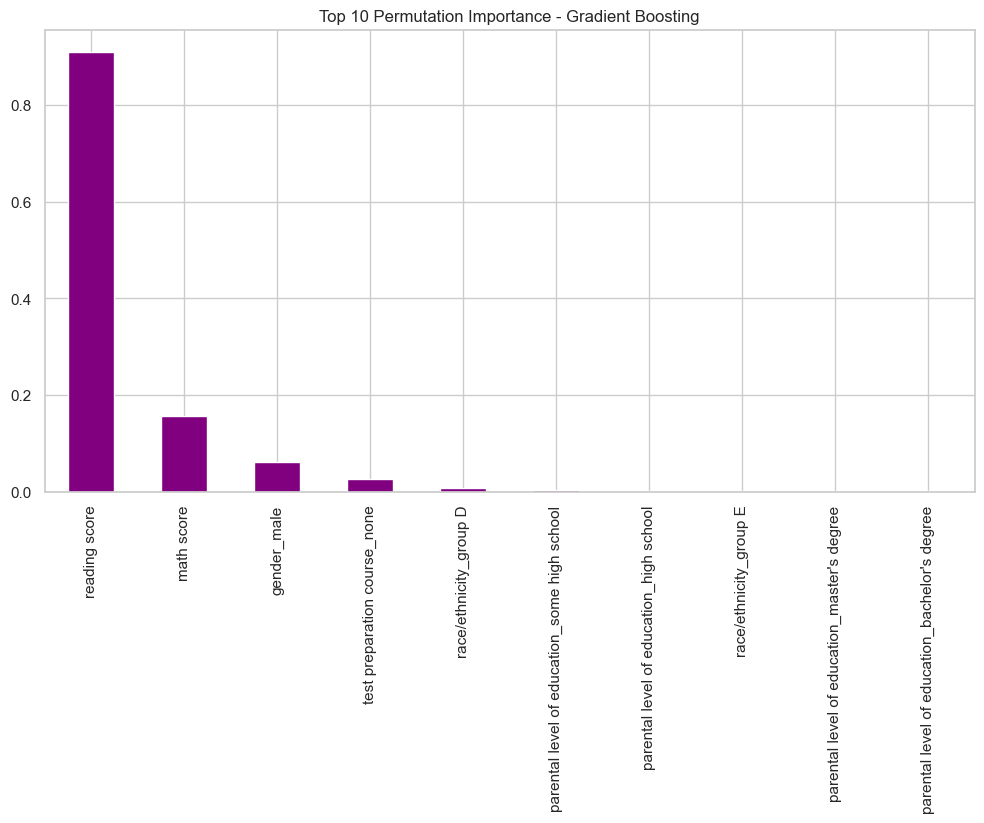

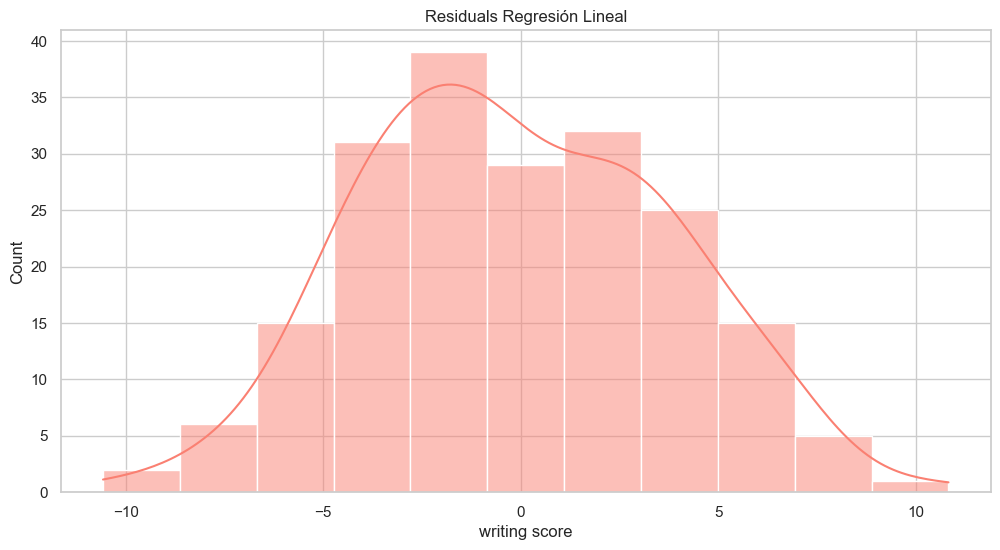

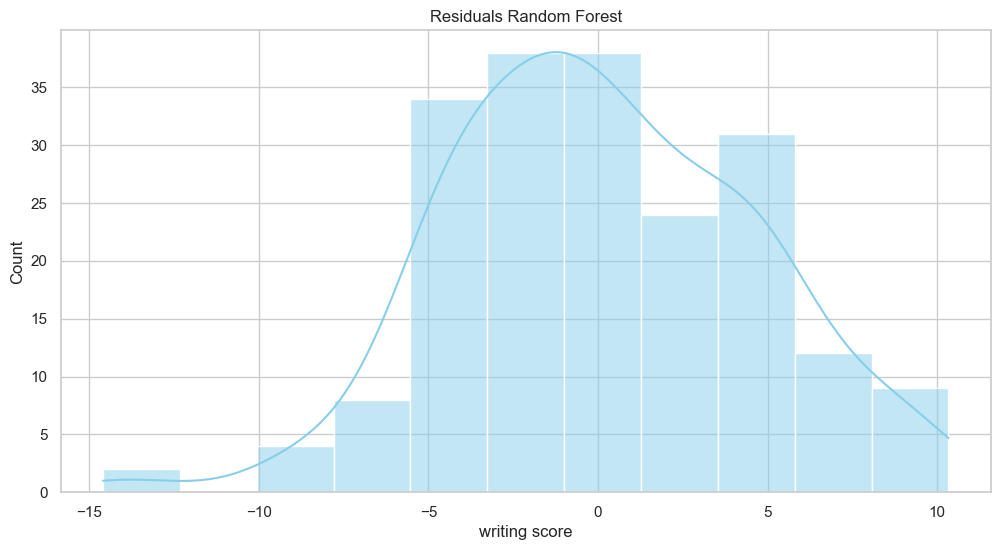

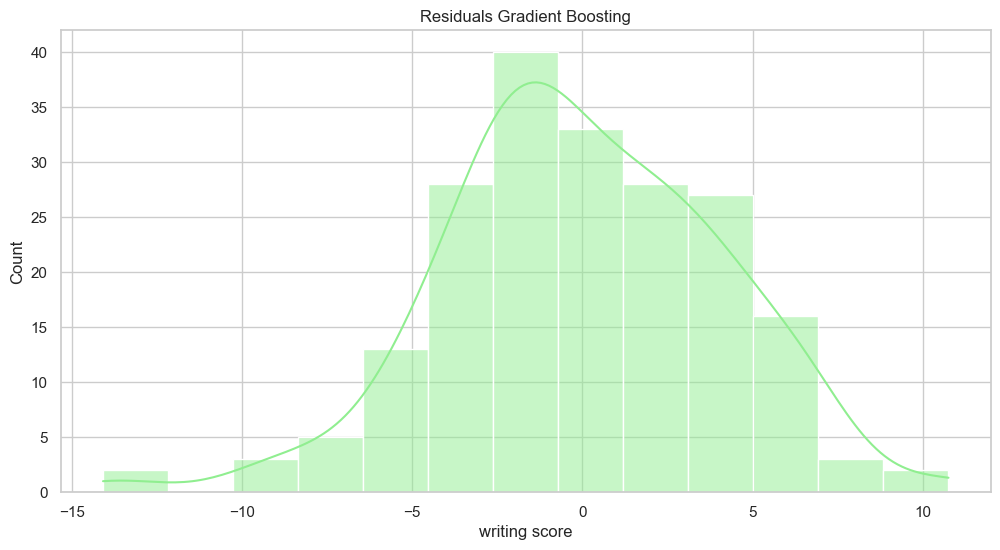


1. Reading Score domina en la importancia de Random Forest y Gradient Boosting debido a su alta correlación con Writing Score.
2. Permutation Importance muestra una distribución más equilibrada de la relevancia de features.
3. Math Score y variables contextuales (género, nivel educativo, preparación) siguen siendo relevantes para predicción.
4. Los modelos basados en árboles manejan mejor outliers y dispersión que la regresión lineal.
5. Para trabajos futuros se recomienda evaluar modelos de ensamblado y considerar remover variables altamente colineales para análisis más interpretables.



In [6]:
# ==================================================
# ProyectoParteIII_Lopez.ipynb - Versión Mejorada
# ==================================================

# ===============================
# Librerías y Configuración utilizadas en el proyecto
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# ==================================================
# Carga del Dataset StudentsPerformance, que lo saca de la carpeta data
# ==================================================
DATA_PATH = "data/StudentsPerformance.csv"
df = pd.read_csv(DATA_PATH)
print("Información general del dataset:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())

# ==================================================
# Variables
# ==================================================
categorical_vars = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
numeric_vars = ['math score','reading score','writing score']
target = 'writing score'

# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Features y target
features = [col for col in df_encoded.columns if col != target]
X = df_encoded[features]
y = df_encoded[target]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==================================================
# Análisis de Colinealidad
# ==================================================
plt.figure(figsize=(8,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlaciones")
plt.show()

# ==================================================
# Feature Selection
# ==================================================
# A) Correlación con target
corr_with_target = pd.Series(index=features, data=[df_encoded[f].corr(y) for f in features])
corr_with_target = corr_with_target.abs().sort_values(ascending=False)

# B) SelectKBest
skb = SelectKBest(score_func=f_regression, k=10)
skb.fit(X_scaled, y)
skb_scores = pd.Series(skb.scores_, index=features).sort_values(ascending=False)

# C) LassoCV
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_scaled, y)
lasso_coefs = pd.Series(lasso.coef_, index=features).sort_values(key=lambda s: s.abs(), ascending=False)

# Resumen comparativo
feature_summary = pd.DataFrame({
    'corr_abs': corr_with_target,
    'skb_score': skb_scores,
    'lasso_coef_abs': lasso_coefs.abs()
}).fillna(0).sort_values(by='skb_score', ascending=False)
print("\nResumen de feature selection:")
print(feature_summary)

# ==================================================
# División Train/Test
# ==================================================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==================================================
# Modelado
# ==================================================
# 1) Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2) Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3) Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# ==================================================
# Evaluación de los Modelos
# ==================================================
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nResultados {nombre_modelo}:")
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return mse, mae, r2

mse_lr, mae_lr, r2_lr = evaluar_modelo(y_test, y_pred_lr, "Regresión Lineal")
mse_rf, mae_rf, r2_rf = evaluar_modelo(y_test, y_pred_rf, "Random Forest")
mse_gb, mae_gb, r2_gb = evaluar_modelo(y_test, y_pred_gb, "Gradient Boosting")

# ==================================================
# Importancia de Features
# ==================================================
# Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
# Gradient Boosting
gb_importances = pd.Series(gb.feature_importances_, index=features).sort_values(ascending=False)

plt.figure()
rf_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Features - Random Forest')
plt.show()

plt.figure()
gb_importances.head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Features - Gradient Boosting')
plt.show()

# ==================================================
# uso de Permutation Importance
# ==================================================
perm_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_gb = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42)

perm_rf_importances = pd.Series(perm_rf.importances_mean, index=features).sort_values(ascending=False)
perm_gb_importances = pd.Series(perm_gb.importances_mean, index=features).sort_values(ascending=False)

plt.figure()
perm_rf_importances.head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Permutation Importance - Random Forest')
plt.show()

plt.figure()
perm_gb_importances.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Permutation Importance - Gradient Boosting')
plt.show()

# ==================================================
# Residuals y Errores
# ==================================================
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_gb = y_test - y_pred_gb

plt.figure()
sns.histplot(residuals_lr, kde=True, color='salmon')
plt.title('Residuals Regresión Lineal')
plt.show()

plt.figure()
sns.histplot(residuals_rf, kde=True, color='skyblue')
plt.title('Residuals Random Forest')
plt.show()

plt.figure()
sns.histplot(residuals_gb, kde=True, color='lightgreen')
plt.title('Residuals Gradient Boosting')
plt.show()

# ==================================================
# Conclusiones Mejoradas
# ==================================================
conclusiones = """
1. Reading Score domina en la importancia de Random Forest y Gradient Boosting debido a su alta correlación con Writing Score.
2. Permutation Importance muestra una distribución más equilibrada de la relevancia de features.
3. Math Score y variables contextuales (género, nivel educativo, preparación) siguen siendo relevantes para predicción.
4. Los modelos basados en árboles manejan mejor outliers y dispersión que la regresión lineal.
5. Para trabajos futuros se recomienda evaluar modelos de ensamblado y considerar remover variables altamente colineales para análisis más interpretables.
"""

print(conclusiones)

# ==================================================
# Guardado de Resultados
# ==================================================
import os
RESULTS_PATH = "resultados"
os.makedirs(RESULTS_PATH, exist_ok=True)

feature_summary.to_csv(os.path.join(RESULTS_PATH,'feature_selection_summary.csv'))
rf_importances.to_csv(os.path.join(RESULTS_PATH,'rf_feature_importances.csv'))
gb_importances.to_csv(os.path.join(RESULTS_PATH,'gb_feature_importances.csv'))
perm_rf_importances.to_csv(os.path.join(RESULTS_PATH,'perm_rf_importances.csv'))
perm_gb_importances.to_csv(os.path.join(RESULTS_PATH,'perm_gb_importances.csv'))

predicciones = pd.DataFrame({
    'y_true': y_test,
    'y_pred_lr': y_pred_lr,
    'y_pred_rf': y_pred_rf,
    'y_pred_gb': y_pred_gb
})
predicciones.to_csv(os.path.join(RESULTS_PATH,'predicciones_modelos.csv'), index=False)

with open(os.path.join(RESULTS_PATH,'conclusiones.txt'), 'w') as f:
    f.write(conclusiones)
